In [1]:

import numpy as np

In [2]:
c = np.array([1, 3, 5,-2, 6, 2,-4, 9,10, 1, 4,-6])
a = np.array([1, 2, 6, 3,-3, 4,-2,-8,-5,-7, 7,-1])
b = np.array([6, 4, 1, 8, 9, 3, 2,12,10,11,0.9,5])
d = [-1 if i<0 else 1 for i in c ]
#print(d)
-np.corrcoef(a*d,b)[0,1]

0.9781826740728177

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
#  %cd /content/gdrive/My Drive

In [5]:
# !pip install lime

In [6]:
# !pip install shap

In [7]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lime
import shap
import matplotlib as plot
import sklearn.metrics
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler


/home/teadem/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [8]:
def loadDataset(dataset):
    if dataset == "boston":
        boston = sklearn.datasets.load_boston()
        boston_df = pd.DataFrame(boston['data'] )
        boston_df.columns = boston['feature_names']
        boston_df['PRICE']= boston['target']
        featureName = boston_df.columns
        y = boston_df['PRICE']
        X = boston_df.iloc[:,0:13]
        return X, y,featureName
    elif dataset == "superconductivity":
        df = pd.read_csv("~/XAI/datasets/train.csv")
        y = df['critical_temp']
        X = df.drop('critical_temp',axis=1)

        return X,y, X.columns
    elif dataset == "diabetes":
        diabetes = sklearn.datasets.load_diabetes()
        diabetes_df = pd.DataFrame(diabetes.data )
        diabetes_df.columns = diabetes.feature_names
        diabetes_df['target']= diabetes['target']

        y = diabetes_df['target']
        X = diabetes_df.drop('target',axis=1)
        return X, y,featureName,X.columns
    else: 
        return None

In [9]:

def split_train_test(X,y,test_size=0.3,randomstate=42,scale=False):
    if scale == False:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=randomstate)
        return X_train,X_test,y_train,y_test
    else:
        sc = StandardScaler()
        X_scaled = sc.fit_transform(X)
        y_scaled = sc.fit_transform(y)

        return train_test_split(X_scaled,y_scaled,test_size=test_size,random_state=randomstate)


In [10]:
def train_model(model, X,y):
    if model == "Linear Regression":
        lr = LinearRegression()
        lr.fit(X,y)
        return lr
    elif model == "Random Forest Regressor":
        rf_r = RandomForestRegressor()
        rf_r.fit(X,y)
        return rf_r
    elif model == "SVR":
        svr = SVR()
        svr.fit(X,y)
        return svr
    else:
        return None


In [11]:

def Explanation(explainer,model,X,X_ref):
    if explainer == "SHAP":
        exp = shap.Explainer(model.predict, X_ref)
        shap_vals = exp(X)
        base_val = shap_vals.base_values 
        return shap_vals,base_val
    elif explainer == "Kernel SHAP":
        exp = shap.KernelExplainer(model.predict, X_ref)
        shap_vals = exp.shap_values(X)
        expected_val = exp.expected_value
        return shap_vals,expected_val
    elif explainer == "Tree SHAP":
        exp = shap.TreeExplainer(model,X_ref)
        shap_vals = exp(X)
        return shap_vals
    elif explainer == "LIME":
        X_np= X.to_numpy()
        featureNames=X.columns
        lime_exp = lime.lime_tabular.LimeTabularExplainer(
            X_np,
            feature_names=featureNames ,
            mode='regression') 
        exp_lime = []
        No_f = len(featureNames)
        for x in X:
            ex = lime_exp.explain_instance(x, 
                model.predict,
                num_features=No_f)
            exp_lime.append(x)
        return exp_lime
    elif explainer == "LIME-SHAP":
        exp_lime = []
#         X_np = np.zeroes()
#         if type(X_np) == numpy.ndarray:
        X_np= X
#         else:
#         X_np = X.to_numpy()
        featureNames=X.columns
        No_features = len(featureNames)
        
        lime_explainer_shap = shap.other.LimeTabular(model.predict,X_np,mode = 'regression')
        lime_attribs = lime_explainer_shap.attributions(X_np,num_features=No_features)
        return lime_attribs
    else:
        return None
'''lime_exp = lime.lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=columns ,
    class_names=['feature_names'], 
    verbose=True, 
    mode='regression')'''

"lime_exp = lime.lime_tabular.LimeTabularExplainer(\n    X_train_np,\n    feature_names=columns ,\n    class_names=['feature_names'], \n    verbose=True, \n    mode='regression')"

In [12]:
def visualize_shap(model,X, shap_value,expected_value,type_of_Vis,explainer_type):
    shap.initjs()
    if explainer_type == "shap":
        if type_of_Vis == "waterfall":
            shap.plots.waterfall(shap_value)
        elif type_of_Vis == "force plot":
            shap.plots.force(shap_value)
        elif type_of_Vis == "beeswarm":
            shap.plots.beeswarm(shap_value)
        elif type_of_Vis == "bar plot":
            shap.plots.bar(shap_value)
    elif explainer == "kernel shap":
        if type_of_Vis == "force plot":
            shap.force_plot(expected_value, shap_value[0], X)
        
            shap.plots.bar(shap_value)
        elif type_of_Vis == "heatmap":
            shap.plots.heatmap(shap_value)
        elif type_of_Vis == "summary plot":
            shap.summary_plot(shap_value, X)


In [13]:
import matplotlib.pyplot as pp
def plot(x):
  pp.plot(x,'-o')
  pp.show()

In [14]:
def faithfulness_metric(model, x, coefs, base):
    predt = model.predict(np.transpose(x.reshape(-1,1)))
    ar = np.argsort(coefs) 
    pred_ts = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        if d<0:
            diff.append(-1)
        else:
            diff.append(1)
        x_copy[ind] = base[ind]
        x_copy_ts = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_ts[ind] = x_copy_ts
    
    return -np.corrcoef(np.array(diff)*coefs, pred_ts)[0,1]


In [15]:
def faithfulness_metric_new(model, x, coefs, base):
    predt = model.predict(np.transpose(x.reshape(-1,1)))
    ar = np.argsort(coefs) 
    pred_ts = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        if d<0:
            diff.append(-1)
        else:
            diff.append(1)
        x_copy[ind] = base[ind]
        x_copy_ts = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_ts[ind] = x_copy_ts - predt
    
    return np.corrcoef(np.array(diff)*coefs, pred_ts)[0,1]

In [16]:
def faithfulness_metric_new1(model, x, coefs, base):
    predt = model.predict(np.transpose(x.reshape(-1,1)))
    ar = np.argsort(coefs) 
    pred_ts = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        x_copy[ind] = base[ind]
        x_copy_ts = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_ts[ind] = x_copy_ts - predt
    
    return -np.corrcoef(coefs, pred_ts)[0,1]

In [17]:
def monotonicity_metric(model, x, coefs, base):
    predict_ = model.predict(np.transpose(x.reshape(-1,1)))
    x_copy = base.copy()
    ar = np.argsort(coefs)
    isPos = [False for i in range(len(ar))]
    pred_tss = np.zeros(x.shape[0])
    
    for ind in np.nditer(ar):
        if coefs[ind]<0:
            isPos[ind] = False
        else:
            isPos[ind] = True
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_tss[ind] = x_copy_pr
    diff = np.diff(pred_tss[ar])
    final_ = []
    for i in range(len(diff)):
        if isPos[i] == False and diff[i] < 0:
            final_.append(True)
        elif isPos[i] == True and diff[i] >=0:
            final_.append(True)
        else:
            final_.append(False)
    return any(final_)


In [18]:
# X,y = loadDataset("boston")
# X_new = X.drop(columns=['ZN','CHAS','RAD'])
# cols = X.columns
# base1 = X[cols].mean()
# base1['ZN'] = int(round(X['ZN'].mean()))
# base1['CHAS'] = 0
# base1['RAD'] = int(round(X['RAD'].mean()))
# base = base1.values
# base1
# (X.to_numpy())[3:,]


In [19]:
def metrics(model,X,shap_val,explainer_type,metrics_type,dataset):
    cols = X.columns
    if dataset == "boston":
      base1 = X[cols].mean()
      base1['ZN'] = int(round(X['ZN'].mean()))
      base1['CHAS'] = 0
      base1['RAD'] = int(round(X['RAD'].mean()))
      base = base1.values
    else:
      base = X[cols].mean().values
    if metrics_type == "faithfulness":
        faithfulne = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                # print(shap_val[i])
                coefs = shap_val[i].values
#                 f = faithfulness_metric_new(model, x, coefs, base)
                f = faithfulness_metric_new1(model, x, coefs, base)
#                 f = faithfulness_metric(model, x, coefs, base)
                # print(f)
                faithfulne.append(f)
        elif explainer_type == "kernel shap":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                # print(shap_val[i])
                coefs = shap_val[i]
#                 f = faithfulness_metric_new(model, x, coefs, base)
                f = faithfulness_metric_new1(model, x, coefs, base)
#                 f = faithfulness_metric(model, x, coefs, base)
                # print(f)
                faithfulne.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = np.array(shap_val)[i]
                f = faithfulness_metric_new1(model, x, coefs, base)
                # print(f)
                faithfulne.append(f)
        plot(faithfulne)
        return np.array(faithfulne).mean()
    elif metrics_type == "monotonicity":
        monotonicity = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = shap_val.values[i]
                f = monotonicity_metric(model, x, coefs, base)
                monotonicity.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = np.array(shap_val)[i]
                f = monotonicity_metric(model, x, coefs, base)
                monotonicity.append(f)
        return monotonicity

In [27]:
def Main(dataset):
    
    X,y,feature_name = loadDataset(dataset)
    sc = StandardScaler()
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    X_scaled = sc.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    if dataset == "diabetes":
        X_trainS,X_testS,y_trainS,y_testS = X_train,X_test,y_train,y_test
    else:
        X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)
    
    LR_model = train_model("Linear Regression",X_train,y_train)
    RF_model = train_model("Random Forest Regressor",X_train,y_train)
    
    SVR_model = train_model("SVR",X_trainS,y_trainS)
    
    print('R2 for Train)', LR_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))
    print('R2 for Train)', RF_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))
    print('R2 for Train)', SVR_model.score( X_trainS, y_trainS))
    
    X100 = shap.maskers.Independent(X, max_samples=100)
    X100_ = shap.utils.sample(X, 10)
    idx = 10
    
    LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[:idx,],X100)
    LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[:idx,],X100_)
    LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)
    
    RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[:idx,],X100)
    RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[:idx,],X100_)
    RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

    ################### evaluation#####################
    
    #faithfulness
    faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[:idx,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for shap Linear reg:",np.mean(np.array(faithfulness_LR_shap)))
    faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[:idx,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for kernel shap Linear reg:",np.mean(np.array(faithfulness_LR_shap_k)))
    faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[:idx,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for shap RF reg:",np.mean(np.array(faithfulness_RF_shap)))
    faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[:idx,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for kernel shap RF reg:",np.mean(np.array(faithfulness_RF_shap_k)))
    
#     return LR_shap,LR_baseVal,LR_shap_k,RF_expected_val_k ,LR_lime, RF_shap, RF_baseVal ,RF_shap_k,RF_expected_val_k ,RF_lime

Boston

R2 for Train) 0.7504301493946856
R2 for Test (cross validation) 0.7026747392041666
R2 for Train) 0.9798176618412509
R2 for Test (cross validation) 0.8896571966033451
R2 for Train) 0.6327844909533993


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

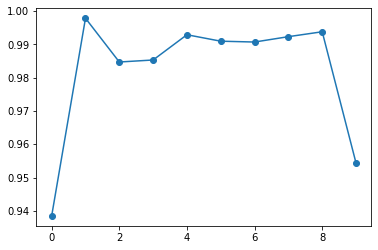

Mean Faithfulness for shap Linear reg: 0.9821112230683202


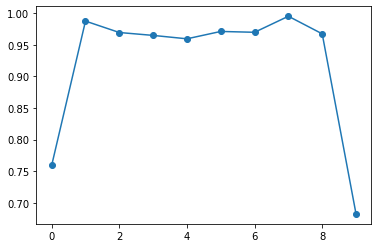

Mean Faithfulness for kernel shap Linear reg: 0.9225862261987915


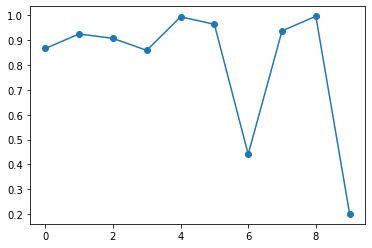

Mean Faithfulness for shap RF reg: 0.8088787411436966


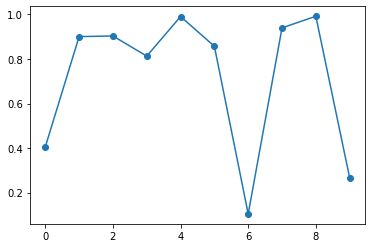

Mean Faithfulness for kernel shap RF reg: 0.7171104627418841


In [28]:
dataset = "boston"
Main(dataset)

In [ ]:
dataset = "superconductivity"
Main(dataset)

R2 for Train) 0.7363146046600055
R2 for Test (cross validation) 0.7390557860708045
R2 for Train) 0.9785710409241584
R2 for Test (cross validation) 0.9281333931006848
R2 for Train) 0.7738556433284732


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
X,y = loadDataset(dataset)
sc = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

In [46]:
len(X.columns)

13

In [47]:
LR_model = train_model("Linear Regression",X_train,y_train)
RF_model = train_model("Random Forest Regressor",X_train,y_train)
SVR_model = train_model("SVR",X_trainS,y_trainS)

In [48]:
print('R2 for Train)', LR_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))

R2 for Train) 0.7551429905772495
R2 for Test (cross validation) 0.6892650044054291


In [49]:
print('R2 for Train)', RF_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))

R2 for Train) 0.9816370820631998
R2 for Test (cross validation) 0.8246425937096157


In [50]:
print('R2 for Train)', SVR_model.score( X_trainS, y_trainS))
# print('R2 for Test (cross validation)', r2_score(y_testS, sc.inverse_transform(SVC_model.predict(X_testS))))


R2 for Train) 0.6907827648600491


In [51]:
X100 = shap.maskers.Independent(X, max_samples=100)
X100_ = shap.utils.sample(X, 100)

In [52]:
# LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

In [53]:
LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[100:,],X100_)



  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
expRF = shap.TreeExplainer(RF_model,X100)

In [ ]:
shap_valuesRF = expRF(X_test.iloc[:i,])

In [54]:
RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[100:,],X100_)
# RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)


  0%|          | 0/27 [00:00<?, ?it/s]

In [57]:
X100S = shap.maskers.Independent(X_trainS, max_samples=100)
X100_S = shap.utils.sample(X_trainS, 100)

In [59]:
SVR_shap, SVR_baseVal = Explanation("SHAP",SVR_model,X_testS[100:,],X100)
SVR_shap_k,SVR_expected_val_k = Explanation("Kernel SHAP",SVR_model,X_testS[100:,],X100_)


Permutation explainer: 28it [00:13,  1.70s/it]                        


  0%|          | 0/27 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [60]:
type(X_testS)

numpy.ndarray

In [61]:
type(X_test)

pandas.core.frame.DataFrame

In [67]:
# SVR_lime1 = Explanation("LIME",SVR_model,X_test,X100)
SVR_lime = Explanation("LIME-SHAP",SVR_model,X_testS,X100)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

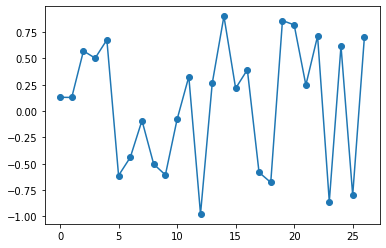

In [74]:
faithfulnes_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

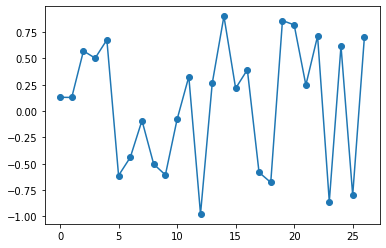

In [76]:
faithfulnes_LR_shap1 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

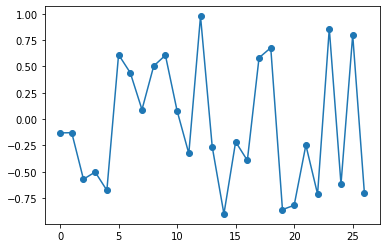

In [78]:
faithfulnes_LR_shap2 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

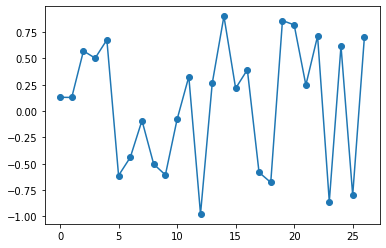

In [82]:
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

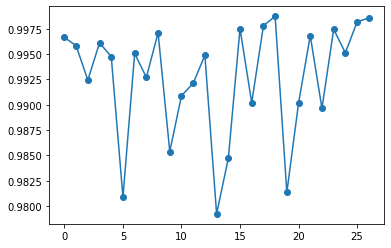

In [86]:
faithfulness_LR_shap_k1 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

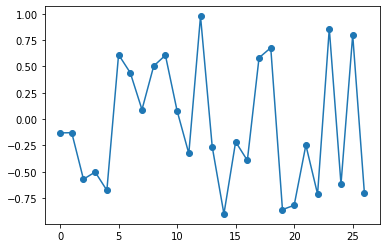

In [88]:
faithfulness_LR_shap_k2 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

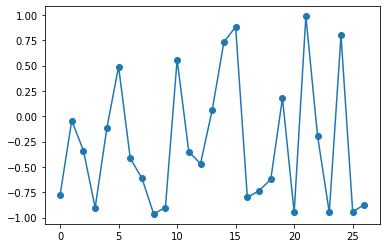

In [90]:
faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

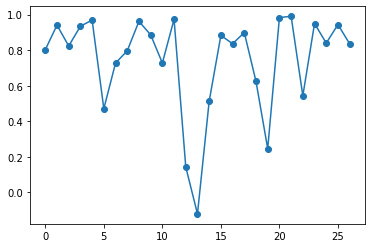

In [92]:
faithfulness_RF_shap1 = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

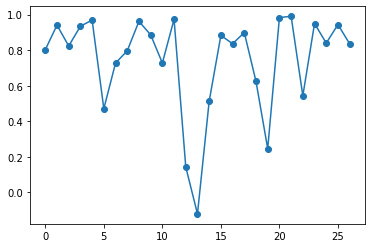

In [94]:
faithfulness_RF_shap2 = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

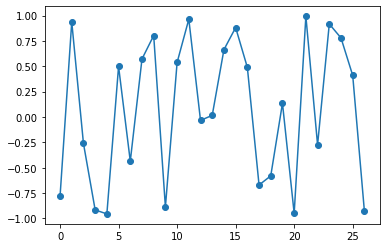

In [96]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

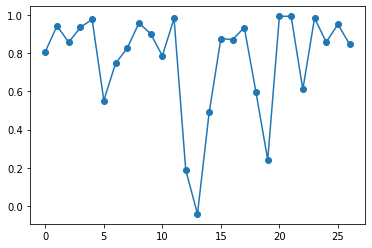

In [98]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

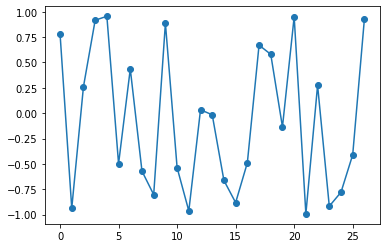

In [100]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

In [13]:
dataset = "superconductivity"

In [14]:
X,y = loadDataset(dataset)
sc = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

In [21]:
y_train

5178      63.00
11113      0.55
19947      3.34
16877     13.10
3990      34.00
          ...  
2453      40.00
719      110.00
13163      3.30
4829      78.00
2714      88.00
Name: critical_temp, Length: 15947, dtype: float64

In [15]:
X_trainS = pd.DataFrame(X_trainS,columns = X_train.columns)
X_testS = pd.DataFrame(X_testS,columns = X_test.columns)
y_trainS = pd.DataFrame(y_trainS,columns = y_train.columns)
y_testS  = pd.DataFrame(X_trainS,columns = y_test.columns)

AttributeError: 'Series' object has no attribute 'columns'

In [22]:
len(X.columns)

81

In [23]:
LR_model = train_model("Linear Regression",X_train,y_train)
RF_model = train_model("Random Forest Regressor",X_train,y_train)
SVR_model = train_model("SVR",X_trainS,y_trainS)

In [24]:
print('R2 for Train)', LR_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))

R2 for Train) 0.7351781389632128
R2 for Test (cross validation) 0.7421395165129345


In [25]:
print('R2 for Train)', RF_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))

R2 for Train) 0.9778102707396914
R2 for Test (cross validation) 0.924672107869921


In [26]:
print('R2 for Train)', SVR_model.score( X_trainS, y_trainS))
# print('R2 for Test (cross validation)', r2_score(y_testS, sc.inverse_transform(SVC_model.predict(X_testS))))


R2 for Train) 0.7719342045175044


In [29]:
X100 = shap.maskers.Independent(X, max_samples=10)
X100_ = shap.utils.sample(X, 10)

In [ ]:
# LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

In [ ]:
LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[5:,],X100)
LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[5:,],X100_)



In [ ]:
RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[5:,],X100)
RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[5:,],X100_)
# RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)


In [ ]:
SVR_shap, SVR_baseVal = Explanation("SHAP",SVR_model,X_test.iloc[100:,],X100)
SVR_shap_k,SVR_expected_val_k = Explanation("Kernel SHAP",SVR_model,X_test.iloc[100:,],X100_)
# RF_lime1 = Explanation("LIME",SVR_model,X_test,X100)
SVR_lime = Explanation("LIME-SHAP",SVR_model,X_test,X100)


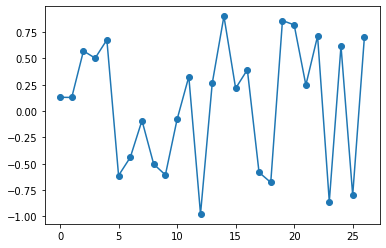

In [74]:
faithfulnes_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

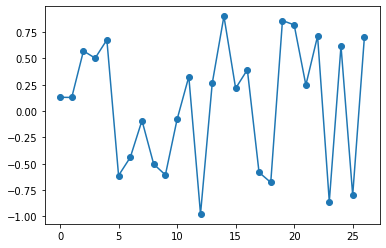

In [76]:
faithfulnes_LR_shap1 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

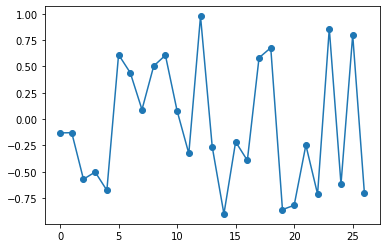

In [78]:
faithfulnes_LR_shap2 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

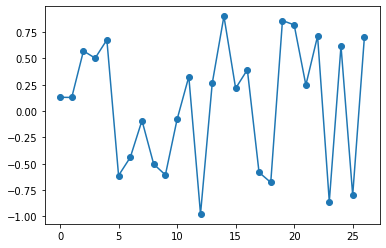

In [82]:
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

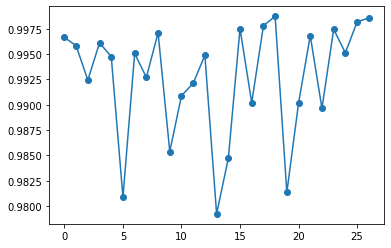

In [86]:
faithfulness_LR_shap_k1 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

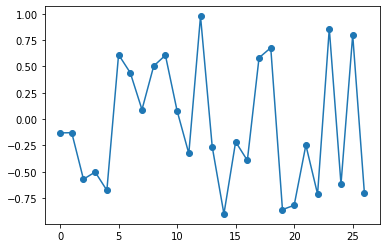

In [88]:
faithfulness_LR_shap_k2 = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

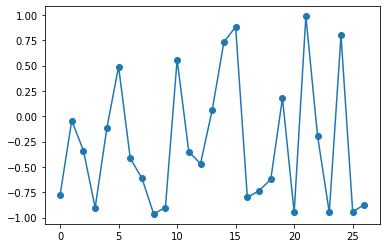

In [90]:
faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

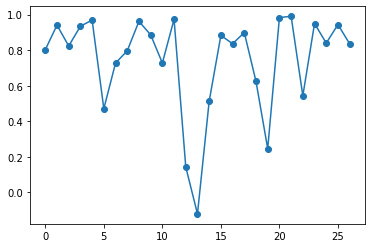

In [92]:
faithfulness_RF_shap1 = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

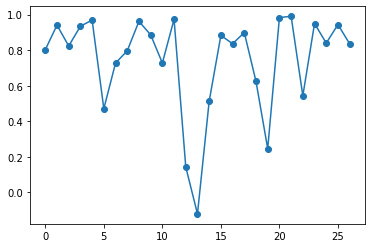

In [94]:
faithfulness_RF_shap2 = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

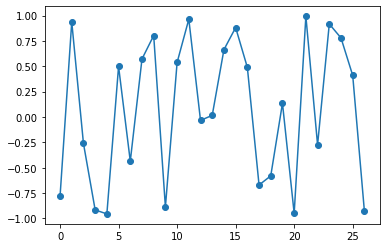

In [96]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

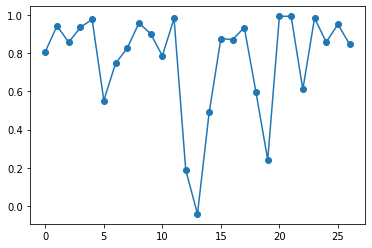

In [98]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

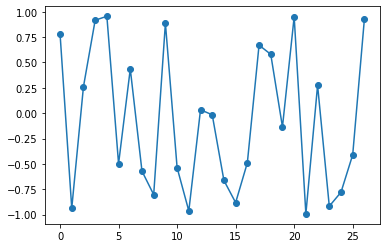

In [100]:
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)

In [20]:
dataset = "diabetes"

In [24]:
X,y = loadDataset(dataset)
sc = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

In [39]:
len(X.columns)

13

In [25]:
LR_model = train_model("Linear Regression",X_train,y_train)
RF_model = train_model("Random Forest Regressor",X_train,y_train)
SVR_model = train_model("SVR",X_trainS,y_trainS)

In [26]:
print('R2 for Train)', LR_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))

R2 for Train) 0.7465410027972057
R2 for Test (cross validation) 0.7171275658250608


In [27]:
print('R2 for Train)', RF_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))

R2 for Train) 0.9842765642812042
R2 for Test (cross validation) 0.8742811091462493


In [28]:
print('R2 for Train)', SVR_model.score( X_trainS, y_trainS))
# print('R2 for Test (cross validation)', r2_score(y_testS, sc.inverse_transform(SVC_model.predict(X_testS))))


R2 for Train) 0.6630363345625185


In [29]:
X100 = shap.maskers.Independent(X, max_samples=100)
X100_ = shap.utils.sample(X, 100)

In [ ]:
# LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

In [31]:
LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[100:,],X100_)



  0%|          | 0/27 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[100:,],X100_)
# RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)


In [ ]:
SVR_shap, SVR_baseVal = Explanation("SHAP",SVR_model,X_test.iloc[100:,],X100)
SVR_shap_k,SVR_expected_val_k = Explanation("Kernel SHAP",SVR_model,X_test.iloc[100:,],X100_)
# RF_lime1 = Explanation("LIME",SVR_model,X_test,X100)
SVR_lime = Explanation("LIME-SHAP",SVR_model,X_test,X100)


Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

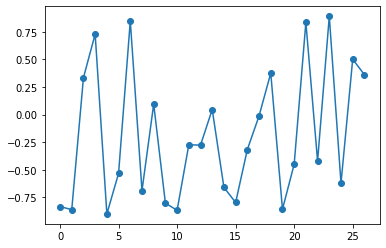

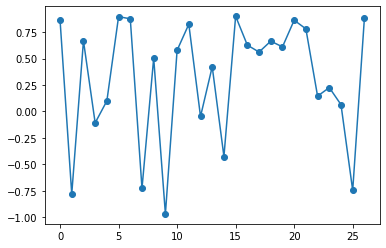

AttributeError: ignored

In [20]:
# x1,x2,x3,x4,
x5,x6,x7,x8 = Main("boston")

In [ ]:
def Main(dataset):
  X,y = loadDataset(dataset)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  LR_model = train_model("Linear Regression",X_train,y_train)
  RF_model = train_model("Random Forest Regressor",X_train,y_train)

  X100 = shap.utils.sample(X, 50)
  # LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[10:,],X100)
  # LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
  # LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  # RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[10:,],X100)
  # RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
  # RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  # print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  # print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_LR_shap_k)
  # print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  # print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_shap_k)
  # print("====================================================================")
  print(monotonicity_LR_shap)
  # print("====================================================================")
  # print(monotonicity_LR_lime)
  # print("====================================================================")
  print(monotonicity_RF_shap)
  # print("====================================================================")
  # print(monotonicity_RF_lime)
  print("====================================================================")
  # return monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap

Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

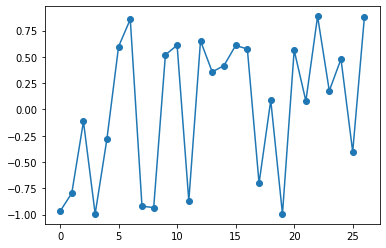

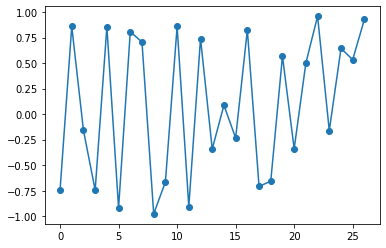

AttributeError: ignored

In [21]:
x5,x6,x7,x8 = Main("boston")#kernel shap

In [ ]:
def Main(dataset):
  X,y = loadDataset(dataset)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  LR_model = train_model("Linear Regression",X_train,y_train)
  RF_model = train_model("Random Forest Regressor",X_train,y_train)

  X100 = shap.utils.sample(X, 50)
  # LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  # LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[10:,],X100)
  # LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
  LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  # RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  # RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[10:,],X100)
  # RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
  RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  # faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

  # monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  # print("====================================================================")
  # print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  print("faithfulness for lime explainer for Linear regression",faithfulness_LR_lime)
  # print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_lime)
  # print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_shap_k)
  # print("====================================================================")
  # print(monotonicity_LR_shap)
  # print("====================================================================")
  # print(monotonicity_LR_lime)
  # print("====================================================================")
  # print(monotonicity_RF_shap)
  # print("====================================================================")
  # print(monotonicity_RF_lime)
  print("====================================================================")
  # return monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap

In [ ]:
x5,x6,x7,x8 = Main("boston")#lime

In [ ]:
# x1,x2,x3,x4,
x5,x6,x7,x8 = Main("superconductivity")

In [ ]:
X,y = loadDataset("boston")
X_train,X_test,y_train,y_test = train_test_split(X,y)
LR_model = train_model("Linear Regression",X_train,y_train)
X100 = shap.utils.sample(X, 1000)
LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)
LR_lime[0]
# len(X.columns)

In [ ]:
X.columns

In [ ]:
LR_lime1 = Explanation("LIME",LR_model,X_test,X100)

In [ ]:
LR_lime1

In [ ]:
faithfulness_LR_shap = metrics(model=LR_model,X=X_test,shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test,shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test,shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test,shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test,shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test,shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test,shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test,shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)

  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print(faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print(faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime)
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime)
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime

In [ ]:
# x1,x2,x3,x4,
x5,x6,x6,x7,x8 = Main("superconductivity")

In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

In [ ]:
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:10])

# init the JS visualization code
shap.initjs()

# transform the indexes to words
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])



In [ ]:
X,y = loadDataset("boston")
X

In [ ]:
X_new = X.drop(columns=['ZN','CHAS','RAD'])
mean = X_new.mean(axis=0)
std = X_new.std(axis=0)



In [ ]:
X,y = loadDataset(dataset)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  LR_model = train_model("Linear Regression",X_train,y_train)
  RF_model = train_model("Random Forest Regressor",X_train,y_train)

  X100 = shap.utils.sample(X, 1000)
  LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[100:,],X100)
  # LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
  # LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[100:,],X100)
  # RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
  # RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime.any())
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime.any())
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap